# Ridge Regression and the Lasso

This notebook provides a comprehensive guide on implementing ridge and lasso regression using scikit-learn libraries.

By: Bryce Li, NUS

This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the sklearn package in order to perform ridge regression and the lasso. The main functions in this package that we care about are Ridge(), which can be used to fit ridge regression models, and Lasso() which will fit lasso models. They also have cross-validated counterparts: RidgeCV() and LassoCV(). We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have been removed from the data, as described in the previous lab.

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
data_df=pd.DataFrame(data)
data_df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS' ,'NOX', 'RM', 'AGE' ,'DIS' ,'RAD', 'TAX', 'PTRATIO','B' ,'LSTAT']

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [11]:
data_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [10]:
target.shape

(506,)

In [13]:
X=data_df
y=target

## Ridge Regression

The Ridge() function has an alpha argument ( $\lambda$
 , but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [12]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a  13×100
  matrix, with 13 rows (one for each predictor) and 100 columns (one for each value of alpha). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the normalize = True parameter:

In [15]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 13)

We expect the coefficient estimates to be much smaller, in terms of  l2
  norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

In [20]:
len(coefs[0])

13

Text(0, 0.5, 'weights')

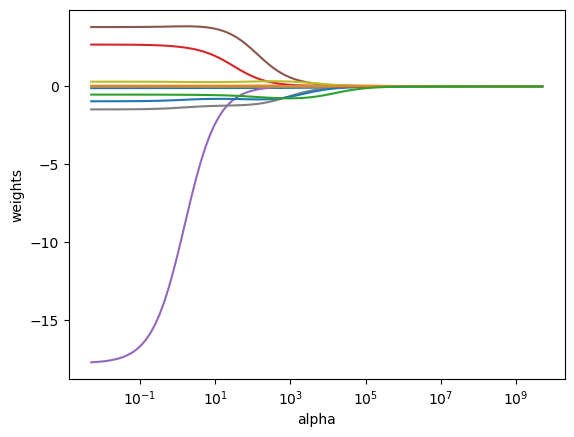

In [16]:
#13 variables--->13 lines, repsect tp change of alpha
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso:

In [21]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  $\lambda=4$:
 

In [30]:
ridge2 = Ridge(alpha = 4)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

CRIM      -0.085045
ZN         0.063195
INDUS     -0.018020
CHAS       1.950710
NOX       -4.651252
RM         2.894820
AGE       -0.009602
DIS       -1.273546
RAD        0.271491
TAX       -0.013078
PTRATIO   -0.809542
B          0.007495
LSTAT     -0.592229
dtype: float64
19.481231131665144


The test MSE when alpha = 4 is 19.4812. Now let's see what happens if we use a huge value of alpha, say  $10^{10}$:

In [24]:
ridge3 = Ridge(alpha = 10**10)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

CRIM      -1.098481e-06
ZN         2.884640e-06
INDUS     -1.037423e-06
CHAS       1.632804e-08
NOX       -1.700406e-08
RM         1.432688e-07
AGE       -3.836620e-06
DIS        2.007836e-07
RAD       -1.040249e-06
TAX       -2.371770e-05
PTRATIO   -3.472341e-07
B          9.310180e-06
LSTAT     -1.713562e-06
dtype: float64
92.01959775551022


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. Recall that least squares is simply ridge regression with alpha = 0.

In [25]:
ridge2 = Ridge(alpha = 0, )
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))  

CRIM       -0.098542
ZN          0.060784
INDUS       0.059172
CHAS        2.439560
NOX       -21.469965
RM          2.795814
AGE         0.003575
DIS        -1.516272
RAD         0.307542
TAX        -0.011280
PTRATIO    -1.005466
B           0.006450
LSTAT      -0.568835
dtype: float64
19.83132367206313


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha  =4
 , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument cv.

In [26]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.026683496156031508

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.02668. What is the test MSE associated with this value of alpha?

In [28]:
ridge4 = Ridge(alpha = ridgecv.alpha_)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

19.790950758839177

In [29]:
mean_squared_error(y_test, ridge2.predict(X_test))

19.83132367206313

This represents no further improvement over the test MSE that we got using alpha  =4
 . Finally, we refit our ridge regression model on the full data set, using the value of alpha=4, and examine the coefficient estimates.

In [32]:
ridge2 = Ridge(alpha = 4)
ridge2.fit(X, y)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))

CRIM      -0.102053
ZN         0.048566
INDUS     -0.032871
CHAS       2.297234
NOX       -4.941782
RM         3.831692
AGE       -0.009909
DIS       -1.286962
RAD        0.279492
TAX       -0.013514
PTRATIO   -0.816431
B          0.009957
LSTAT     -0.545113
dtype: float64
16.998564994598013


## The Lasso

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

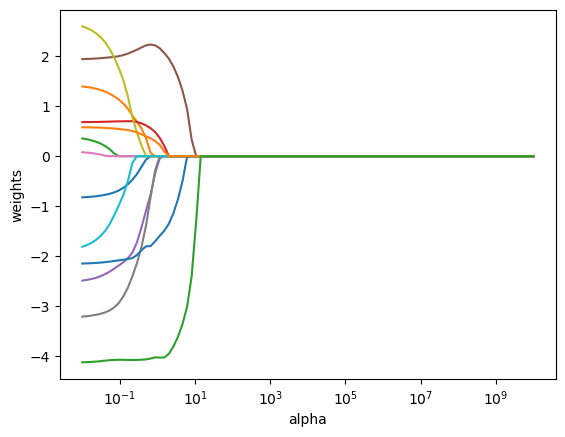

In [35]:
lasso = Lasso(max_iter = 10000, )
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [36]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000,  )
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

25.85112591587626

In [37]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

CRIM      -0.063236
ZN         0.061322
INDUS     -0.000000
CHAS       0.000000
NOX       -0.000000
RM         1.030035
AGE        0.008768
DIS       -0.789775
RAD        0.251766
TAX       -0.013440
PTRATIO   -0.737649
B          0.006720
LSTAT     -0.731296
dtype: float64

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 3 of the 13 coefficient estimates are exactly zero: